# Casualties and Migration in the Syrian Civil War

## Introduction

***

In 2011, five weeks into the civil demonstrations against the Syrian government, secret police forces detained and tortured fifteen students who had spray painted an anti-government statement on the walls of their school. They would be released weeks later in an effort to quell the rising civil unrest in the province. In the wake of the hundreds of other demonstrators who were killed or disappeared, this action was too little and too late to stop the tide of the civil war. Demonstrations turned to protest turned to armed conflict and the rest is history.

The war would go on to spawn both the largest refugee crisis and one of the deadliest conflicts in modern history. As of 2019, there are over 6 million Syrian refugees and another 6 million internally displaced people in a country with a pre-war population of around 24 million (UNHCR, 2018). The regime's efforts to prevent accurate information from leaving the country has made it nearly impossible to estimate the number of casualties that have occured in that time. Current estimates range from 300,000 to 600,000 killed depending on the source.

The link between the flow of violence within the country and the flow of asylum seekers out of the country should be apparent to anyone who is aware of the war. Yet a growing sentiment among residents in host countries is that a large portion of asylum seekers from Syria are actually economic migrants, who are using the conflict as a means of gaining entry into the European Union and access to generous social programs.

We believe that violence is the most important predictor of migration of Syrian refugees; however, while this argument may be generally accepted, there is great difficulty in proving this relationship for certain. We hope to answer this question using reported casualty data to see whether there is a correlation between violence in a given province and a subsequent increase in the amount of asylum seekers across all host countries.

## Project
***

Our project can be organized into three distinct portions:

1. Data Scraping
2. Data Wrangling
3. Data Visualization

Our goal is to create a dataset for casualty information a refugee data, clean and structure the dataset for easier queying, and visualize the data to provide more insights into the questions we pose above. 

## Data Scraping
***

There are multiple sources that could be used for casualty information (list here). We will leave the three datasets for now, and focus on the VDC and CSR datasets because they provide their data is table elements that make it easy for us to scrape and organize our dataframes for analysis.

We will now go through the process of scraping and creating the inital forms of these datasets.

### Casualty Data
***

#### VDC

The [Violations Documentation Center](http://www.vdc-sy.info/) has been recording casualty data since June 2011. It is likely the most detailed and complete (in terms of metadata) data source of casualties that is publicly accessible.

They provide their data with a user interface that will query their database using parameter the user defines. This interface will provide this information:

- `Name                  - Full name in English`
- `Status                - Civilian, non-civilian, or military status of deceased`
- `Sex                   - Whether deceased is an Adult or Minor and Male or Female`
- `Province              - One of the 14 Provinces of Syria`
- `Area \ Place of Birth - Various locations that can be Provinces/Subdistricts/Towns`
- `Date of death         - self explanatory`
- `Cause of death        - self explanatory`
- `Actors                - groups involved in the casualty`

Each entry is associated with a unique identifier, which is an integer between 0 and 250,000. Clicking on the name of the entry will lead the user to another page that provides the unique identifier number and other data that is not displayed on the main page. We will avoid describing this detail for now, since most of this data is not used in the final product.

We will describe the full process we used to scrape all details from this website as well as the detailed information.

In [ ]:
def scrape_recent():
    first_page = 'http://www.vdc-sy.info/index.php/en/martyrs/1/c29ydGJ5PWEua2lsbGVkX2RhdGV8c29ydGRpcj1ERVNDfGFwcHJvdmVkPXZpc2libGV8ZXh0cmFkaXNwbGF5PTB8'
    
    # This is the format of the links that give us the unique identfiers
    pattern    = re.compile('\/index\.php\/en\/details\/martyrs\/.')

    # We want to establish a randomized user agent and Tor node to avoid detection
    ua         = UserAgent()
    headers    = {'User-Agent': ua.random}
    tor        = TorRequest(password = 'commonhorse')
    
    try:
        response = tor.get(first_page, headers=headers)
        content  = bs(response.text, 'html.parser')
        
        # This list comprehension grabs all unique identifiers in string format for all links that match
        # our regex pattern from above
        links    = {link['href'][30:] for link in content.find_all('a', href = True) if pattern.match(link['href'])} 

    except Exception as e:
        print(e)

    return links

In [ ]:
'''
Provided a list of unique identifiers in string fromat, scrapes details and saves each entry 
as an idividual dataframe that represents one person.
'''

def scrape_details(uid, tor, headers):
    cols = []
    vals = []

    url  = 'http://www.vdc-sy.info/index.php/en/details/martyrs/' + uid
    
    # Headers will provide the UserAgent to use when getting response
    # Makes the request using a TorRequest object passed in
    page = tor.get(url, headers = headers).text
    page = bs(page, 'html.parser')
    
    # Grabs the relevant table info and all rows in it
    table = page.find('table', attrs = {'class':'peopleListing'})
    rows  = table.find_all('tr')

    for row in rows:
        data = row.find_all('td')

        # All data without only 2 data values
        # are not data we are looking for
        if len(data) != 2:
            continue

        # data[0] corresponds to the row label/column
        cols.append(data[0].text)
        
        # Values need to appended differently for image rows 
        if data[1].find('img') is not None:
            vals.append(data[1].find('img')['src'])
        else:
            vals.append(data[1].text)

    # Adds the uid to the dataframe
    cols.append('uid')
    vals.append(uid)

    # Creates and saves dataframe
    person = pd.DataFrame([vals], columns = cols, dtype=str)

    save(person, os.path.join('person_dfs', uid))
    
    
    

Each detailed page has a different number of columns depending on the metadata associated with that entry, so we will now have to combine all the dataframes. Pandas requires that columns have unique names, so we have to rename all duplicate columns using this code.

In [ ]:
def rename_dup_cols(dataframe):
    cols = pd.Series(dataframe.columns)
  
    for dup in dataframe.columns.get_duplicates(): 
        cols[dataframe.columns.get_loc(dup)] = [dup + '_' + str(d_idx) if d_idx != 0 else dup for d_idx in range(dataframe.columns.get_loc(dup).sum())]
   
    dataframe.columns = cols

    return dataframe




Now given a list of dataframes we can return a combined dataframe that retains all column data and saves that file as vdc_df and saves any failed dataframes as failed_vdc_df.

In [ ]:
def combine_dataframes(dataframes):
    failed_dataframes = []
    combined          = pd.DataFrame()

    current = 0
    num     = len(dataframes)

    for df in dataframes:
        try:
            combined = pd.concat([combined, df], axis = 0)
            print(f'{counter} / {num} people processed in combine_dataframes().')
            counter += 1
        
        except Exception as e:
            failed_dataframes.append(df)
            print('Failed')
            counter += 1

    save(combined, 'vdc_df')
    save(failed_dataframes, 'failed_vdc_df')

    print('\n\nSuccess: ', len(dataframes) - len(failed_dataframes))
    print('Failed: ', len(failed_dataframes))
    
    
    

Now, adding this all together. We will now:

1. Build a list of unique identifiers by scraping the query page for the VDC database using scrape_recent()

2. Scrape the detailed information provided the list of unique ids from scrape_recent() using scrape_details, which gives us dataframes for each person.

3. Combine those dataframes into one large dataset using combine_dataframes()


In [ ]:
uids_to_scrape = scrape_recent()
uids_scraped   = set()

while len(uids_to_scrape) > 0:
    uid = uids_to_scrape.pop()
    
    try:
        ua         = UserAgent()
        headers    = {'User-Agent': ua.random}
        tor        = TorRequest(password = 'cmps184')
        scrape_details(uid, tor, headers)

    except Exception as e:
        print(e)
        helen___uids_to_scrape.append(uid)

        ua         = UserAgent()
        headers    = {'User-Agent': ua.random}
        tor        = TorRequest(password = 'cmps184')
        tor.reset_identity()

        continue
        
    uids_scraped.add(uid)

    save(uids_to_scrape, 'uids_to_scrape')
    save(uids_scraped  , 'uids_scraped')

In [ ]:
list_of_dataframes = []

for person_df in glob.glob(os.path.join('person_dfs', '*.pickle')):
    list_of_dataframes.append(load(person_df))
    
combine_dataframes(list_of_dataframes)

#### CSR

The [Syrian Center for Statistics and Research](https://csr-sy.org/) has been recording casualty data since March 2011. It has less information than the VDC dataset, but the location of death is more precise.

They provide their data with a user interface that will query their database using parameter the user defines. This interface will provide this information:

- `ID Number             - Arbitrary ID number`
- `First Name            - First name in Arabic`
- `Father Name           - Father's last name in Arabic`
- `Last Name             - Last name in Arabic`
- `Province              - One of the 14 Provinces of Syria`
- `Town                  - Town where they died`
- `Date of death         - self explanatory`

For some reason, the CSR website was cautious about who was looking at their data as it blocked our multiple attempts of trying to scrape without cycling through IP addresses and user agents. Therefore, having the Tor and user agent library was essential in scraping this data.

The following section contain all the libraries that must be imported in order to run the web scraping. 

In [5]:
# for requesting content of a web page
from bs4 import BeautifulSoup
from requests import get

# for regex
# import re

# for dataframe creation
import pandas as pd

# for not overwhelming server when scraping pages
from time import sleep
from random import randint

# For a progress bar while scraping
from tqdm import tqdm

# For saving files
import pickle

# For shuffling list
import random

# For Tor Requests
from torrequest     import TorRequest

# To cycle through useragents
from fake_useragent import UserAgent

ModuleNotFoundError: No module named 'torrequest'

In order to not have to rescrape everything if one page fails, it is essential to have a pickle file that you can store your successfully scraped data and failed attempts in. Below is the code to create and load a pickle file.

In [ ]:
# Save and Load functions for a pickle file
def save(obj, name):
    pickle.dump(obj, open(name + '.pickle', 'wb'))

def load(name):
    return pickle.load(open(name + '.pickle', 'rb'))

In [ ]:
# the url to start scraping CSR
url = 'https://csr-sy.org/?l=1&sons=redirect&sequence=&name=&father_name=&surname=&age_from=0&age_to=120&gender=&born_state=&born_town=&career=&society_status=&sons_no=&medical_status=&incident_state=&incident_town=&incident_desc=3&incident_date_from=&incident_date_to=&incident_details=&trial=&trial_date_from=&trial_date_to=&id=182&ddate_from=&ddate_to=&rec=0'

response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')

The website was odd in the sense that some pages at the end didn't contain any information about Syrian casualties. We found the last page that had any information and hard-coded the page number in. As you can see from the code below, 91900 was the last page to contain any useful information.

In [ ]:
# create a list of numbers used in shuffling through all the URLs
numbers_url = [str(i) for i in range(0, 91901, 50)]

# shuffling the numbers so that the website doesn't become suspicious of us
random.shuffle(numbers_url)
numbers_url = set(numbers_url)

In [ ]:
# all the pickle files: the good, the bad, and the ugly
data_list     = load('csr_data_list')
failed_urls   = load('failed_urls')
finished_urls = load('finished_urls')

# removes the URL number if that corresponding page has been scraped successfully
for url in finished_urls:
    try:
        numbers_url.remove(url)
    except:
        continue

# tqdm() creates a progress bar to see how far you are from finishing your task
# scrapes the website in a random order while cycling through IP addresses and user agents
for number_url in tqdm(numbers_url):
    try:
        # being cautious
        sleep(randint(30,60))
        ua         = UserAgent()
        user_agent = ua.random
        headers    = {'User-Agent': user_agent}
        tor = TorRequest(password = 'commonhorse')
        tor.reset_identity()
        
        url = 'https://csr-sy.org/?l=1&sons=redirect&sequence=&name=&father_name=&surname='        + \
                '&age_from=0&age_to=120&gender=&born_state=&born_town=&career=&society_status='    + \
                '&sons_no=&medical_status=&incident_state=&incident_town=&incident_desc=3'         + \
                '&incident_date_from=&incident_date_to=&incident_details=&trial=&trial_date_from=' + \
                '&trial_date_to=&id=182&ddate_from=&ddate_to=&rec=' + number_url


        response = tor.get(url, headers = headers)

        html_soup = BeautifulSoup(response.text, 'html.parser')
        rows = html_soup.findAll('tr', {'title':'victim'})

        # start scraping one page
        for row in rows:
            columns = row.findAll('td')

            # saves the column data
            for i in range(len(columns)):
                if i == 0:
                    continue
                else:
                    data_list[i - 1].append(columns[i].text)
                    
        finished_urls.append(number_url)
        
        # stores the successfully scraped data
        save(data_list    , 'csr_data_list')
        # stores the finished URL number
        save(finished_urls, 'finished_urls')
    
    # pages that failed are stored in the pickle file failed_urls
    except Exception as e:
        print(e)
        print('\nFailed on: ', number_url)
        failed_urls.append(number_url)
        save(failed_urls, 'failed_urls')
        continue

When we're done with all the pages, we want to convert our saved pickle file into a CSV file (to make loading in the data easier).

In [ ]:
# creates a data frame
victim_info = pd.DataFrame({
    'victim_id'  : data_list[0],
    'first_name' : data_list[1],
    'father_name': data_list[2],
    'last_name'  : data_list[3],
    'province'   : data_list[4],
    'town'       : data_list[5],
    'date'       : data_list[6]    
})

# saves our file as a CSV file
victim_info.to_csv(index=false)

### Refugee Data

#### Monthly Inflows

The [UN Refugee Agency [UNHCR]](http://popstats.unhcr.org/en/asylum_seekers_monthly) provides monthly refugee data in csv format with the following attributes:

- `Years                 `
- `Months                `
- `Country / territory of asylum/residence                   `
- `Origin  `

The monthly data is from 1999-2018 and there are 38 European and 6 non-European countries provided about asylum applications. We selected data from the years 2011 - 2018 to focus on the the time frame of the Syrian Civil War which stared in March 15, 2011. You can download the csv file by selecting the following categories:
- `Years: 2011-2018                 `
- `Months: All months               `
- `Country / territory of asylum/residence: All countries/territories                   `
- `Origin: Syrian Arab Republic `

The csv file is readily available so we did not have to do any further scraping.


#### Libraries used for Refugee Data

In [10]:
import pandas as pd
import time
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.plotly as py
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
plotly.__version__
init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='katy27', api_key='gnvKtGJNSZTspVTRINvI')

In [8]:
# load csv file into pandas dataframe
refugee_month_df = pd.read_csv('2011-2018_monthly_refugee.csv')

#### Yearly Refugee Status

The [UN Refugee Agency [UNHCR]](https://data.world/unhcr/e2d5566d-d755-40dd-a63f-d4d298a9df1d/workspace/file?filename=unhcr-persons-of-concern-origin-syr-csv-1.csv) provides year-by-year data from 1968-2017 concerning refugee migrations and more population concerns originating from Syria. We can can access this data in csv format easily, however the link provided may ask the user to sign in with a dataworld account or  google/facebook profile. The dataset contains the following attributes:

- `Year                 `
- `Country / territory of asylum/residence                `
- `Origin                   `
- `Refugees (incl. refugee-like situations  `
- `Asylum-seekers (pending cases)                 `
- `Returned refugees               `
- `Internally displaced persons (IDPs)                `
- `Returned IDPs  `
- `Stateless persons                 `
- `Total Population `

We are interested in selecting the following columns and filter our data frame accordingly:
- `Year                 `
- `Country / territory of asylum/residence                `
- `Origin                   `
- `Refugees (incl. refugee-like situations  `
- `Asylum-seekers (pending cases)                 `
- `Total Population `


In [11]:
# load csv file into pandas dataframe
refugee_year_df = pd.read_csv('unhcr-persons-of-concern-origin-syr-csv-1.csv')

# sort dataframe by ascending years
refugee_year_df = refugee_year_df.sort_values('Year', ascending=True)

# adjust index of dataframe
refugee_year_df = refugee_year_df.reset_index()
refugee_year_df = refugee_year_df.drop(refugee_year_df.index[0])
refugee_year_df = refugee_year_df.drop(['index'], axis=1)

We filter the dataset by selecting specific columns as well as time between 2011 and 2017.

In [12]:
# select the years we want
years = ['2011', '2012', '2013', '2014', '2015','2016', '2017']

refugee_subset = refugee_year_df[refugee_year_df['Year'].isin(years)]

# reset index
refugee_subset = refugee_subset.reset_index()

# drop index column
bad_cols = ['index','Origin','Returned refugees','Returned refugees',
            'Internally displaced persons (IDPs)','Returned IDPs',
            'Stateless persons','Others of concern']
refugee_subset = refugee_subset.drop(bad_cols, axis=1)

## Data Wrangling

### Casualty Data

#### VDC

You can run the cell below to see what the dataset looks like without any modification.

In [ ]:
vdc_df = load('vdc_df')
vdc_df

While the added details we got from scraping everythign from the website are valuable for more detailed analysis, these particular columns will be what we will be focusing on with this project:

- `Name                  `
- `Status                `
- `Sex                   `
- `Province              `
- `Area \ Place of Birth `
- `Date of death         `
- `Cause of death        `
- `Actors                `

And we can create a dataframe we will use to do all of their data frame so that we are not modifying the original dataset.

In [ ]:
scratch = vdc_df[['Province',
                  'Sex',
                  'Status',
                  'Date of death',
                  'Cause of Death']].copy()

If we look at the `Sex` column, we can see that there is actually data about the person's minority status and age range, so we will create new columns to capture that information.

In [ ]:
# We'll first want to drop any rows that don't have this information
scratch = scratch.dropna(subset=['Sex'])

def check_age(row):
    if 'Adult' in row['Sex']:
        val = 'adult'
    else:
        val = 'minor'
    return val

scratch['age_cat'] = scratch.apply(check_age, axis=1)

def check_sex(row):
    if 'Male' in row['Sex']:
        val = 'male'
    else:
        val = 'female'
    return val

scratch['sex'] = scratch.apply(check_sex, axis=1)

If we look at the `Cause of Death` coolumn, we'll see that there is some reduntant categories, so we'll simplify these categories by remapping those values based on a dictionary mapping we show below.

In [ ]:
cause_of_death_map = {'Chemical and toxic gases'         : 'Chemical Weapon',
                      'Detention - Execution'            : 'Detention',
                      'Detention - Torture'              : 'Detention',
                      'Detention - Torture - Execution'  : 'Detention',
                      'Explosion'                        : 'Explosion',
                      'Field Execution'                  : 'Execution',
                      'Kidnapping - Execution'           : 'Execution',
                      'Kidnapping - Torture'             : 'Execution',
                      'Kidnapping - Torture - Execution' : 'Execution',
                      'Other'                            : 'Unknown'  ,
                      'Shelling'                         : 'Shelling' ,
                      'Shooting'                         : 'Shooting' ,
                      'Siege'                            : 'Siege'    ,
                      'Un-allowed to seek Medical help'  : 'Lack of Medical Access',
                      'Unknown'                          : 'Unknown'  ,
                      'Warplane shelling'                : 'Shelling' 
}

def check_cause_of_death(row, mapping):
    return mapping[row['Cause of Death']]

scratch['cause_of_death'] = scratch.apply(check_cause_of_death,
                                        args = (cause_of_death_map, ),
                                        axis = 1)

For convenience we can change the status column

In [ ]:
def check_status(row):
    if row['Status'] == 'Non-Civilian':
        val = 'non_civilian'
    elif row['Status'] == 'Civilian':
        val = 'civilian'
    else:
        val = 'regime'
    return val

scratch['status'] = scratch.apply(check_status, axis=1)

Now that the dataset is cleaner, we can drop columns that irrelevant to us, and rename the columns for convenience.

In [ ]:
scratch = scratch[['Province',
                  'sex',
                  'status',
                  'age_cat',
                  'Date of death',
                  'cause_of_death']].copy()

scratch.columns = ['province', 'sex', 'status', 'age_cat','date_of_death', 'cause_of_death']



We will now drop any entries with unrecroded or icorrect dates of death and convert the time strings to python datetime objects.

With all of those modifcations we can finally save this dataset as complete.

In [ ]:
scratch = scratch[scratch['province'].isin(picked)]
scratch = scratch[scratch['date_of_death'] != '0000-00-00']
scratch = scratch[scratch['date_of_death'] != '1970-01-01']
scratch['date_of_death'] = pd.to_datetime(scratch['date_of_death'])

save(scratch, 'clean_vdc_df')

#### CSR

### Refugee Data

#### Monthly Inflows

Plotly requires country codes in order to plot countries. We found a csv file of country codes that work with Plotly on [Kaggle](https://www.kaggle.com/shep312/plotlycountrycodes). 

In [13]:
countries_df = pd.read_csv('plotly_countries_and_codes.csv')

We went through our refugee data and changed country names to make it compatible with the Plotly country names in order to join the two data frames. These are the countries we had to replace:
- `Czech Rep. -> Czech Republic `
- `United Kingdom of Great Britain and Northern Ireland -> `
- `Rep. of Korea -> Korea, South  `
- `The former Yugoslav Rep. of Macedonia -> Macedonia`
- `USA (INS/DHS) -> United States   `
- `USA (EOIR) -> United States`
- `USA (EOIR) -> United States `

#### Rename countries

In [14]:
# replace names in refugee_subse dataframe
new_refugee_month_df = refugee_month_df.replace({
    'Czech Rep.': 'Czech Republic',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'Rep. of Korea': 'Korea, South',
    'The former Yugoslav Rep. of Macedonia': 'Macedonia',
    'USA (INS/DHS)': 'United States',
    'USA (EOIR)': 'United States',
    'Serbia and Kosovo: S/RES/1244 (1999)': 'Serbia'
})

#### Merge refugee data with Plotly country codes

In [15]:
# joining two tables together
merged_month_df = new_refugee_month_df.set_index('Country / territory of asylum/residence').join(countries_df.set_index('COUNTRY'))
merged_month_df = merged_month_df.reset_index()
merged_month_df.rename(columns={'index': 'Country'}, inplace=True)

# remove * and convert values to int values
merged_month_df['Value'] = merged_month_df['Value'].apply(lambda x : 0 if x == '*' else int(x))

# sum values and group each country by year
total_month_df = pd.DataFrame(merged_month_df.groupby(['Country','Year','CODE']).agg({'Value':np.sum})).reset_index()

#### Add latitude and longitude for each country to dataframe

In [16]:
locations_df = pd.read_csv('countries.csv')

total_month_sum_df= total_month_df.set_index('Country').join(locations_df.set_index('name'))
total_month_sum_df = total_month_sum_df.reset_index()
total_month_sum_df = total_month_sum_df.drop(['country'], axis=1)
total_month_sum_df.rename(columns={'index':'Country'}, inplace=True)

#### Add missing data

In [17]:
# rename Korea, South to South Korea
name_change = {
    'Korea, South': 'South Korea'
}

# renames the provinces using name_change
total_month_sum_df.replace(name_change, inplace=True)

# add coordinates for South Korea 
total_month_sum_df.at[[163,164,165,166,167,168,169,170], 'latitude'] = 35.9078
total_month_sum_df.at[[163,164,165,166,167,168,169,170], 'longitude'] = 127.7669

# add coordinates for and Macedonia
total_month_sum_df.at[[202,203,204,205,206,207,208,209], 'latitude'] = 41.6086
total_month_sum_df.at[[202,203,204,205,206,207,208,209], 'longitude'] = 21.7453

#### Finalize Clean Up

In [18]:
# drop NaN values
total_month_sum_df = total_month_sum_df.dropna(subset=['CODE'])

# sort values in ascending order
dropped_nan_month_df = total_month_sum_df[pd.notnull(total_month_sum_df['Country'])].sort_values('Year', ascending=True)
dropped_nan_month_df = dropped_nan_month_df.reset_index()
dropped_nan_month_df = dropped_nan_month_df.drop(['index'], axis=1)

#### Yearly Refugee Status

We went through our refugee data and changed country names to make it compatible with the Plotly country names in order to join the two data frames. These are the countries we had to adjust.
- `Venezuela (Bolivarian Republic of) -> Venezuela           `
- `Czech Rep. -> Czech Republic `
- `Iran (Islamic Rep. of) -> Iran`
- `The former Yugoslav Republic of Macedonia -> Macedonia`
- `Bolivia (Plurinational State of) -> Bolivia              `
- `Dominican Rep. -> Dominican Republic`
- `Rep. of Korea -> Korea, South  `
- `South Sudan -> Sudan`
- `Dem. Rep. of the Congo -> Congo, Democratic Republic of the                `
- `Central African Rep. -> Central African Republic`
- `United States of America -> United States `
- `Sint Maarten (Dutch part) -> Sint Maarten`
- `Serbia and Kosovo (S/RES/1244 (1999)) -> Serbia `
- `Rep. of Moldova -> Moldova`
- `Syrian Arab Rep. -> Syria`

#### Rename countries

In [19]:
# replace names in refugee_subse dataframe
new_refugee_df = refugee_subset.replace({
    'Venezuela (Bolivarian Republic of)':'Venezuela',
    'Czech Rep.':'Czech Republic',
    'Iran (Islamic Rep. of)':'Iran',
    'The former Yugoslav Republic of Macedonia':'Macedonia',
    'Bolivia (Plurinational State of)':'Bolivia',
    'Dominican Rep.':'Dominican Republic',
    'Rep. of Korea': 'Korea, South',
    'United Rep. of Tanzania':'Tanzania',
    'China, Hong Kong SAR':'Hong Kong',
    'South Sudan':'Sudan',
    'Dem. Rep. of the Congo':'Congo, Democratic Republic of the',
    'Central African Rep.':'Central African Republic',
    'United States of America':'United States',
    'Sint Maarten (Dutch part)':'Sint Maarten',
    'Serbia and Kosovo (S/RES/1244 (1999))':'Serbia',
    'Rep. of Moldova':'Moldova',
    'Syrian Arab Rep.':'Syria', 
    'Russian Federation':'Russia',
})

#### Merge refugee data with Plotly country codes

In [20]:
# joining the two tables together
merged_df = new_refugee_df.set_index('Country / territory of asylum/residence').join(countries_df.set_index('COUNTRY'))

# reset row index
merged_df = merged_df.reset_index()

# remove GDP column
merged_df = merged_df.drop(['GDP (BILLIONS)'], axis=1)

# rename index column to 'Country'
merged_df.rename(columns={'index':'Country'}, inplace=True)

# rearrange columns
merged_df = merged_df[['CODE','Country','Year',
                       'Refugees (incl. refugee-like situations)',
                       'Asylum-seekers (pending cases)',
                       'Total Population']]

#### Clean Data

Our data set contains NaN values and * for missing data. We need to change these to 0. We do 

In [21]:
# Fill NaN values with 0

filter_rows = ['Refugees (incl. refugee-like situations)','Asylum-seekers (pending cases)','Total Population']
for i in filter_rows:
    # Fill NaN values with 0
    merged_df[i] = merged_df[i].fillna(0)
    # remove * and convert values to int values
    merged_df[i] = merged_df[i].apply(lambda x : 0 if x == '*' else int(x))

The data provided is cummulative, so we select the last year available which is 2017 to represent data from 2011-2017.

In [22]:
# select rows where the refugee data is not 0
new_total_df = merged_df[merged_df['Refugees (incl. refugee-like situations)'] != 0]

year_df = new_total_df[new_total_df['Year'] == '2017']
year_df = year_df.reset_index()
year_df = year_df.drop(['index'], axis=1)

We need the latitude and longitude for each country so we are using from ?????.

In [23]:
# load locations csv file into a dataframe
locations_df = pd.read_csv('countries.csv')

total_sum_df= year_df.set_index('Country').join(locations_df.set_index('name'))
total_sum_df = total_sum_df.reset_index()
total_sum_df = total_sum_df.drop(['country'], axis=1)
total_sum_df.rename(columns={'index':'Country'}, inplace=True)

total_sum_df.at[26,'CODE'] = 'CI'

# # drop rows where CODE is none
total_sum_df = total_sum_df.dropna(subset=['CODE','Refugees (incl. refugee-like situations)'])
total_sum_df.to_csv('total_sum_refugee_data.csv',index=False, header=True)

In [24]:
dropped_nan_df = total_sum_df[pd.notnull(total_sum_df['Country'])]
dropped_nan_df = dropped_nan_df.sort_values('Refugees (incl. refugee-like situations)', ascending=False)
dropped_nan_df = dropped_nan_df.reset_index()
dropped_nan_df = dropped_nan_df.drop(['index'], axis=1)

## Data Visualization

### Casualty Data

#### VDC

#### Year-by-Year

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas_bokeh

import os
import json

# call this so that running plot_bokeh won't create 
# a new window and results will be shown in notebook
pandas_bokeh.output_notebook()

Since the data is provincial for VDC, we decided to use the provincial shapefile to map the data.

In [ ]:
# read the shape file and save it as a geo data frame
shp_file = os.path.join('syr_admin_shp_utf8_18219', 'syr_admin1.shp')
map_df   = gpd.read_file(shp_file)

In [ ]:
# read the VDC csv file and save it as a pandas data frame
dataset = pd.read_csv('vdc_data.csv', encoding='latin-1', dtype=str)

The VDC data set's "Date of death" column contains the month, day, and year the person died, but we only wanted to see the yearly fluctuations. Therefore, we took a substring of the date.

In [ ]:
# data has month and day, so we took a substring of the year of death
dataset['Year of Death'] = dataset['Date of death'].str[:4]

# counts the number of times a province is in the dataset for a certain year
province_count = dataset.groupby(['Province', 'Year of Death']).count()

In [ ]:
# remove unnecessary columns to make data frame smaller
simplified_df = province_count.drop(province_count.columns[1:], axis=1)
simplified_df = simplified_df.reset_index()

In [ ]:
# remove unnecessary columns to make data frame smaller
simplified_df = province_count.drop(province_count.columns[1:], axis=1)
simplified_df = simplified_df.reset_index()

The slider for Bokeh maps works with column titles, not row values, so we had to pivot the table. The once "Date of death" values became column titles and the count of Syrian casualties for that particular year and country became the value.

In [ ]:
# make it so years are columns rather than values
year_as_column = simplified_df.pivot_table('Unnamed: 0', 'Province', 'Year of Death')
year_as_column.reset_index(inplace=True)

In [ ]:
# dropping irrelevant years
year_as_column = year_as_column.drop(['0000', '1970'], axis=1)

Some of the province names in the VDC data set and the shapefile for Syria were not the same, so we had to go through the names manually and see which ones were different so that we could match the different names.

In [ ]:
# changing province names by hand
name_change = {
    'Damascus Suburbs': 'Rural Damascus',
    'Daraa': 'Dar\'a',
    'Deir Ezzor': 'Deir-ez-Zor',
    'Hasakeh': 'Al-Hasakeh',
    'Idlib': 'Idleb',
    'Raqqa': 'Ar-Raqqa',
    'Sweida': 'As-Sweida'
}

# renames the provinces using name_change
year_as_column.replace(name_change, inplace=True)

In [ ]:
# joining data from casualties (VDC) and geo data frame (shape file)
merged = year_as_column.set_index('Province').join(map_df.set_index('NAME_EN'))
merged.reset_index(inplace=True)

In [ ]:
# dropping irrelevant information
# row where there were no data for geo data
merged = merged.drop([10, 15], axis=0)
# columns with information not pertaining to creating choropleth map
merged.drop(merged.columns[9:16], axis=1, inplace=True)

The problem with plot_bokeh() is that it only takes immutable objects. However, the Pandas dataframe is mutable. Therefore, in order to bypass this problem, we decided to convert the Pandas dataframe into a GeoDataFrame. The following code describes that process.

In [ ]:
# Pandas dataframe to GeoDataFrame
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = merged['geometry']
merged_gdf = merged.drop(['geometry'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(merged_gdf, crs=crs, geometry=geometry)

In [ ]:
# specify slider columns:
slider_columns = ["201%d"%i for i in range(1, 8)]
slider_range = range(2011, 2018)

# make slider plot:
gdf.plot_bokeh(
    figsize=(900, 600),
    slider=slider_columns,
    slider_range=slider_range,
    slider_name="Year", 
    colormap='Inferno',
    hovertool_columns=["Province"],
    title="Deaths in Syria",
)

#### Year-by-Year with plotly and mapbox

In [ ]:
# import pickle and read the file
import pickle
final = pickle.load(open('./death_by_province_by_year.pickle', 'rb'))

In [ ]:
# reference: https://plot.ly/python/scattermapbox/
# reference: https://community.periscopedata.com/t/36nz2s/plotly-choropleth-with-slider-map-charts-over-time
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# this is a public mapbox token
mapbox_access_token = 'pk.eyJ1IjoibWF0dGhld2lydHoiLCJhIjoiY2p3ZTNpNXlnMHYxcjQ5bzdwMjc0anlpeSJ9.bSLA-SSqEomk0hC52rNliQ'

In [ ]:
# first year
year = 2011

# for every year we need the latitude, longitude, and the # of casualties
# we use a for loop to store the data for each year of the Syrian War
data_slider = []
for year in final['year'].unique():
    sect =  final[(final['year']== year)]

    for col in sect.columns:
        sect[col] = sect[col].astype(str)
        
    data_each_yr = go.Scattermapbox(
        name=str(year),
        lat=['36.2021',
             '33.5138',
             '33.5167',
             '32.6264',
             '35.3297',
             '35.1409',
             '36.5079',
             '34.7324',
             '35.9310',
             '33.1219',
             '35.5407',  
             '35.9594',  
             '32.7129', 
             '34.8959'],
        lon=['37.1343',
             '36.2765',
             '36.9541',
             '36.1033',
             '40.1350',
             '36.7552',
             '40.7463',
             '36.7137',
             '36.6418',
             '35.8209',
             '35.7953', 
             '38.9981',  
             '36.5663',
             '35.8867'],
        text=["Aleppo",
              "Damascus",
              "Rural Damascus",
              "Daraa",
              "Deir Ezzor",
              "Hama",
              "Hasakeh",
              "Homs",
              "Idlib",
              "Lattakia",
              "Quneitra", 
              "Ar Raqqah", 
              "As Suwayda",
              "Tartus"],
        mode='markers',
        marker = go.scattermapbox.Marker(
            size = sect['casualties'].astype(int),
            color = 'rgb(255, 0, 0)',
            sizemode = 'area',
        ), visible=False
    )
    data_slider.append(data_each_yr)

In [ ]:
# the steps are for each of the possible places our slider can rest
steps = []
for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Year {}'.format(i + 2011))
    step['args'][1][i] = True
    steps.append(step)
    
sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

In [ ]:
# sets up our frame with the mapbox
layout = go.Layout(
    showlegend=False,
    title = go.layout.Title(
            text = '2011-2018 Syrian Casualties'
        ),
    autosize=True,
    hovermode='closest',
    sliders=sliders,
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=34.7,
            lon=37.2
        ),
        pitch=0,
        zoom=5.4
    ),
)

In [ ]:
# visualize
fig = go.Figure(data=data_slider, layout=layout)
py.iplot(fig, filename='Multiple-Mapbox.html')
# plot(fig, filename='Multiple-Mapbox.html')
# use ^ to have the graph open into a seperate tab

#### Day-by-Day

The <b>Day-by-Day</b> code is similar to the <b>Year-by-Year</b> code, so we hope the viewer doesn't mind if we have less comments in this one.

In [ ]:
import pickle

In [ ]:
# read the shape file and save it as a geo data frame
shp_file = os.path.join('syr_admin_shp_utf8_18219', 'syr_admin1.shp')
map_df   = gpd.read_file(shp_file)

In [ ]:
# load the pickle objects as a pandas data frame
day_df = pickle.load(open('./death_by_province_by_day.pickle', 'rb'))

# read the VDC csv file specifically for column "geometry"
dataset = pd.read_csv('vdc_data.csv', encoding='latin-1', dtype=str)

In [ ]:
# changing province names by hand
name_change = {
    'Damascus Suburbs': 'Rural Damascus',
    'Daraa': 'Dar\'a',
    'Deir Ezzor': 'Deir-ez-Zor',
    'Raqqa': 'Ar-Raqqa',
    'Sweida': 'As-Sweida',
    'Idlib': 'Idleb',
    'Hasakeh': 'Al-Hasakeh',
}

# renames the provinces using name_change
day_df.replace(name_change, inplace=True)

In [ ]:
# make it so days are columns rather than values
pivoted_df = day_df.pivot_table('casualties','province','day').fillna(0)

In [ ]:
# joining the data frames in order to obtain the geo data
use = pivoted_df.join(map_df.set_index('NAME_EN'))

In [ ]:
# removing any unnecessary columns
ready = use.drop(columns=['NAM_EN_REF','NAME_AR','PCODE','ADM0_EN','ADM0_AR','ADM0_PCODE','UPDATE_DAT'])

The total number of days from the first date of death to the last date of death is 2,686 days. Therefore, we created 2,686 columns for each day. (Note: this may take a while to finish running.)

In [ ]:
# remove the "year-month-day time" and replace it with the "day"
for i in range(0, 2687):
    ready = ready.rename(index=str, columns={ready.columns[i]: str(i)})

In [ ]:
# Pandas dataframe to GeoDataFrame
from geopandas import GeoDataFrame
from shapely.geometry import Point

geometry = ready['geometry']
crs = {'init': 'epsg:4326'}
day_gdf = GeoDataFrame(ready, crs=crs, geometry=geometry)

In [ ]:
# make 'province' a column
day_gdf = day_gdf.reset_index()

The problem with our visualization is that most of the deaths are in the single to double digits. Very few times do the number of deaths on a single day go into the triple digits. However, the color bar is uniformly split, and we weren't able to find documentation on how to split up the bokeh color bar up, so we brute forced that colors in the color bar.<br><br>
What we wanted to display was that between 0 and 100, the difference in hue would be greater than the difference in hue between 101-600. Therefore, there would be a bigger variety of colors on the map at a certain time.

In [ ]:
# specify slider columns
slider_columns = []
for i in range (0, 2687):
    slider_columns.append(str(i))

slider_range = range(0, 2687)

# make slider plot
day_gdf.plot_bokeh(
    figsize=(900, 600),
    slider=slider_columns,
    slider_range=slider_range,
    slider_name="Day",
    # brute force color bar for map
    colormap=['#edf8f3', '#dcf2e8', '#cbebdd', '#b9e5d2', '#a8dfc7', '#97d8bc', '#85d2b1', '#74cba6', '#63c59b', '#52bf90',
              '#52bf90', '#49ab81', '#419873', '#398564', '#317256', '#295f48', '#204c39', '#18392b', '#18392b', '#18392b', 
              '#10261c', '#10261c', '#10261c', '#10261c', '#10261c', '#10261c', '#10261c', '#10261c', '#10261c', '#10261c', 
              '#0a1812', '#0a1812', '#0a1812', '#0a1812', '#0a1812', '#0a1812', '#0a1812', '#0a1812', '#0a1812', '#0a1812',
              '#08140f', '#08140f', '#08140f', '#08140f', '#08140f', '#08140f', '#08140f', '#08140f', '#08140f', '#08140f', 
              '#07110c', '#07110c', '#07110c', '#07110c', '#07110c', '#07110c', '#07110c', '#07110c', '#07110c', '#07110c', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', 
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
              '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e', '#08130e',
    ],
    hovertool_columns=["province"],
    title="Deaths in Syria",
)

#### Day-by-Day Cumulative Sum

In [ ]:
import pandas as pd
import os
import geopandas as gpd
import json
import pickle
import matplotlib.pyplot as plt
import pandas_bokeh
import datetime
pandas_bokeh.output_notebook()

from geopandas import GeoDataFrame
from shapely.geometry import Point

In [ ]:
# functions to read and write to pickle files
def save(obj, name):
    pickle.dump(obj, open(name + '.pickle', 'wb'))

def load(name):
    return pickle.load(open(name + '.pickle', 'rb'))

In [ ]:
# sets up the map of syria
shp_file = os.path.join('syr_admin_shp_utf8_18219', 'syr_admin1.shp')
map_df   = gpd.read_file(shp_file)

In [ ]:
# we change the names of some of the provinces
name_change = {
    'Damascus Suburbs': 'Rural Damascus',
    'Daraa'           : 'Dar\'a',
    'Deir Ezzor'      : 'Deir-ez-Zor',
    'Hasakeh'         : 'Al-Hasakeh',
    'Idlib'           : 'Idleb',
    'Raqqa'           : 'Ar-Raqqa',
    'Sweida'          : 'As-Sweida'
}

dayFrame = load('death_by_province_by_day')
dayFrame.replace(name_change, inplace=True)

In [ ]:
# we manipulate the dataframe to form a cumulative sum
# fill in the NA values
# put it in the form to be used with a slider in bokeh
pivotedDF         = dayFrame.groupby(by=['province', 'day']).sum().groupby(level=[0]).cumsum()
pivotedDF.columns = ['count']
pivotedDF         = pivotedDF.pivot_table(index = 'day', columns = 'province', values = 'count')
pivotedDF.iloc[0] = pivotedDF.iloc[0].fillna(0)
pivotedDF         = pivotedDF.fillna(method='ffill')
pivotedDF         = pivotedDF.transpose()
pivotedDF         = pivotedDF.reset_index()
pivotedDF.columns = [x.strftime('%m/%d/%Y') if type(x) is not str else x for x in pivotedDF.columns]

In [ ]:
# join with the GEO data
use = pivotedDF.set_index('province').join(map_df.set_index('NAME_EN'))

In [ ]:
# change what the frame is indexed by
use.reset_index(inplace=True)

In [ ]:
# drop the columns that aren't being used
ready = use.drop(columns=['NAM_EN_REF','NAME_AR','PCODE','ADM0_EN','ADM0_AR','ADM0_PCODE','UPDATE_DAT'], axis=1)
ready.index = list(ready.index)

In [ ]:
# create our GeoDataFrame
m_geometry   = ready['geometry']
m_merged_gdf = ready.drop(['geometry'], axis=1)
m_crs        = {'init': 'epsg:4326'}
m_gdf        = GeoDataFrame(m_merged_gdf, crs=m_crs, geometry=m_geometry)

In [ ]:
# Specify slider columns:
m_slider_columns = list(m_gdf.columns)[1:-1]
m_slider_range   = range(0, 2687)

In [ ]:
# Make slider plot:
m_gdf.plot_bokeh(
    figsize           = (900, 600),
    slider            = m_slider_columns,
    slider_range      = m_slider_range,
    slider_name       = "Day", 
    colormap          = "Inferno",
    hovertool_columns = ["province"],
    title             = "Deaths in Syria",
)

#### CSR

### Refugee Data

#### Monthly Inflows

#### Resources

Slider:
https://community.periscopedata.com/t/36nz2s/plotly-choropleth-with-slider-map-charts-over-time
https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu

In [25]:
colorscale = [
        [0,"#E1F5FE"], #50
        [0.0001,"#E1F5FE"],
        [0.0001,'#c4ebfc'],
        [0.001,"#c4ebfc"], 
        [0.001,"#B3E5FC"], #100
        [0.01,"#B3E5FC"],
        [0.01,"#81D4FA"], #200
        [0.1,"#81D4FA"],
        [0.1,"#4FC3F7"], #300
        [0.2,"#4FC3F7"],
        [0.2,"#29B6F6"], #400
        [0.3,"#29B6F6"],
        [0.3,"#03A9F4"], #500
        [0.4,"#03A9F4"],
        [0.4,"#039BE5"], #600
        [0.5,"#039BE5"],
        [0.5,"#0288D1"], #700
        [0.6,"#0288D1"],
        [0.6,"#0277BD"], #800
        [0.7,"#0277BD"], 
        [0.7,"#01579B"], #900
        [0.8,"#01579B"], 
        [0.8,"#00457c"], #1000
        [0.9,"#00457c"],
        [0.9,"#002f56"], #1100
        [1.0,"#002f56"],  
    ]

data_slider = []
for year in dropped_nan_month_df['Year'].unique():
    # break apart data for each year
    df_segmented =  dropped_nan_month_df[(dropped_nan_month_df['Year']== year)]
    for col in df_segmented.columns:
        df_segmented[col] = df_segmented[col].astype(str)
    
    data_each_yr= dict(
                        type='choropleth',
                        locations = df_segmented['CODE'],
                        z=df_segmented['Value'],
                        zmin = 0,
                        zmax = 300000,
                        locationmode='europe',
                        autocolorscale=False,
                        text =df_segmented['Country'],
                        colorscale = colorscale,
                        colorbar= {'title':'Number of Syrian Refugees'})
    
    #flight paths section
    text_data = df_segmented['Country']+": "+df_segmented['Value']
    countries = [ dict(
        type = 'scattergeo',
#         locationmode = 'europe',
        lon = df_segmented['longitude'],
        lat = df_segmented['latitude'],
        hoverinfo = 'text',
        text = text_data,
        mode = 'markers',
         marker = dict(
            size=2,
            color='rgb(255, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            ))
    )]
    
    
    refugee_paths = []
    syria_start_lon = 38.996815
    syria_start_lat = 34.802075
    maximum_value = float(df_segmented['Value'].max())
    for i in range( len( df_segmented ) ):
#         print("i:",i)
        opacity = 0
        
        country_refugee = df_segmented['Value'].iloc[i]
        opacity = float(country_refugee) / maximum_value
        #doing this because otherwise, the lines to countries besides Germany are invisible
        if opacity < 0.25:
            opacity = 0.25

        refugee_paths.append(
            dict(
                type = 'scattergeo',
#                 locationmode = 'USA-states',
                lon = [ syria_start_lon, df_segmented['longitude'].iloc[i] ],
                lat = [ syria_start_lat, df_segmented['latitude'].iloc[i] ],
                mode = 'lines',
                line = dict(
                    width = 1,
                    color = 'red',
                ),
                opacity=opacity,

            )
        )
    
    
    data_slider.append(data_each_yr)
# https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu
# create steps for the slider
steps = []
for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='{}'.format(i + 2011))
    step['args'][1][i] = True
    steps.append(step)
    
# create 'sliders' object from the 'steps'
sliders = [dict(active=0, pad={"t": 1}, steps=steps)]

layout = dict(title ='2011-2018 Syrian Refugee Migration Patterns',
              geo=dict(
                  projection=dict(type='equirectangular'),
                  showland=True,
                  landcolor='rgb(243,243,243)',
                  countrycolor='rgb(204,204,204)',
                  scope='europe'
              ),
              sliders=sliders)

fig = dict(data=data_slider, layout=layout)
# fig = go.Figure(data = data_slider, layout = layout)
py.iplot(fig, validate = False, filename = 'd3-world-map')

C:\Users\huanl\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~katy27/0 or inside your plot.ly account where it is named 'd3-world-map'


C:\Users\huanl\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



#### See how flow of Refugees change over time

In [26]:
# uncomment out print statements to see top 
# countries of most migrations for each year 2011-2018
for year in dropped_nan_month_df['Year'].unique():
    year_df =  dropped_nan_month_df[(dropped_nan_month_df['Year']== year)]
    country_df = year_df.sort_values('Value', ascending=False)
    country_df = country_df.reset_index()
#     country_df = country_df.drop(['index'], axis=1)
#     print(country_df[:5])
#     print("\n")   

#### Yearly Refugee Status

#### Resources

Choropleth:
https://plot.ly/python/choropleth-maps/

Flight paths:
https://plot.ly/pandas/lines-on-maps/ 

In [28]:
data = [go.Choropleth(
    locations = dropped_nan_df['CODE'],
    z = dropped_nan_df['Refugees (incl. refugee-like situations)'],
    text = dropped_nan_df['Country'],
    colorscale = [
        [0,"#E1F5FE"], #50
        [0.0001,"#E1F5FE"],
        [0.0001,'#c4ebfc'],
        [0.001,"#c4ebfc"], 
        [0.001,"#B3E5FC"], #100
        [0.01,"#B3E5FC"],
        [0.01,"#81D4FA"], #200
        [0.1,"#81D4FA"],
        [0.1,"#4FC3F7"], #300
        [0.2,"#4FC3F7"],
        [0.2,"#29B6F6"], #400
        [0.3,"#29B6F6"],
        [0.3,"#03A9F4"], #500
        [0.4,"#03A9F4"],
        [0.4,"#039BE5"], #600
        [0.5,"#039BE5"],
        [0.5,"#0288D1"], #700
        [0.6,"#0288D1"],
        [0.6,"#0277BD"], #800
        [0.7,"#0277BD"], 
        [0.7,"#01579B"], #900
        [0.8,"#01579B"], 
        [0.8,"#00457c"], #1000
        [0.9,"#00457c"],
        [0.9,"#002f56"], #1100
        [1.0,"#002f56"],  
    ],
       
    zmin = 0,
    #zmax = 600000,
    zmax = 1000000,
    autocolorscale = False,
    reversescale = False,
#     marker = go.choropleth.Marker(
#         line = go.choropleth.marker.Line(
#             color = 'rgb(180,180,180)',
#             width = 0.5
#         )),
    colorbar = go.choropleth.ColorBar(
        tickprefix = '',
        title = 'Number of Syrian Refugees'),


)]

# following code is for lines connecting countries
countries = [go.Scattergeo(
    lon = total_sum_df['longitude'],
    lat = total_sum_df['latitude'],
    hoverinfo = 'text',
    text = total_sum_df['Country'],
    mode = 'none',
#     marker = go.scattergeo.Marker(
#         size = 0,
#         color = 'rgb(255, 0, 0)',
#         line = go.scattergeo.marker.Line(
#             width = 3,
#             color = 'rgba(68, 68, 68, 0)'
#         ))
    )]

refugee_paths = []

syria_start_lon = 38.996815
syria_start_lat = 34.802075
maximum_value = float(dropped_nan_df['Refugees (incl. refugee-like situations)'].max())

for i in range(len(dropped_nan_df)):
    # setting the opacity of the lines
    opacity = 0
    country_refugee = dropped_nan_df['Refugees (incl. refugee-like situations)'][i]
    opacity = float(country_refugee) / maximum_value
    # doing this because otherwise, the lines to countries besides Germany are invisible
    if opacity < 0.25:
        opacity = 0.25
        
    refugee_paths.append(
        go.Scattergeo(
            locationmode = 'country names',
            lon = [syria_start_lon, dropped_nan_df['longitude'][i]],
            lat = [syria_start_lat, dropped_nan_df['latitude'][i]],
            mode = 'lines',
            hoverinfo='none',
            line = go.scattergeo.Line(
                width = 1,
                color = 'red',
            ),
            opacity = opacity,
        )
    )

layout = go.Layout(
    showlegend = False,
    title = go.layout.Title(
        text = '2011-2018 Syrian Refugee Migration Patterns'
    ),
    
    geo = go.layout.Geo(
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular',
        ),
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)', 
    ),
    
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Source: <a href="http://popstats.unhcr.org/en/asylum_seekers_monthly">\
            Asylum-Seekers (Monthly Data)</a>',
        showarrow = False
    )]
)

fig = go.Figure(data = data +refugee_paths , layout = layout)
py.iplot(fig, validate = False, filename = 'd3-world-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~katy27/0 or inside your plot.ly account where it is named 'd3-world-map'


In [29]:
max_countries = dropped_nan_df.sort_values('Refugees (incl. refugee-like situations)', ascending=False)
max_countries.head(10)

,Country,CODE,Year,Refugees (incl. refugee-like situations),Asylum-seekers (pending cases),Total Population,latitude,longitude
0,Turkey,TUR,2017,3424237,163,3424400,38.963745,35.243322
1,Lebanon,LBN,2017,992127,8,994383,33.854721,35.862285
2,Jordan,JOR,2017,653031,0,653031,30.585164,36.238414
3,Germany,DEU,2017,496674,70833,567507,51.165691,10.451526
4,Iraq,IRQ,2017,247057,0,247057,33.223191,43.679291
5,Egypt,EGY,2017,126688,0,126688,26.820553,30.802498
6,Sweden,SWE,2017,103614,3531,107145,60.128161,18.643501
7,Austria,AUT,2017,43888,3937,47825,47.516231,14.550072
8,Netherlands,NLD,2017,30851,668,31519,52.132633,5.291266
9,Denmark,DNK,2017,19221,285,19506,56.263920,9.501785


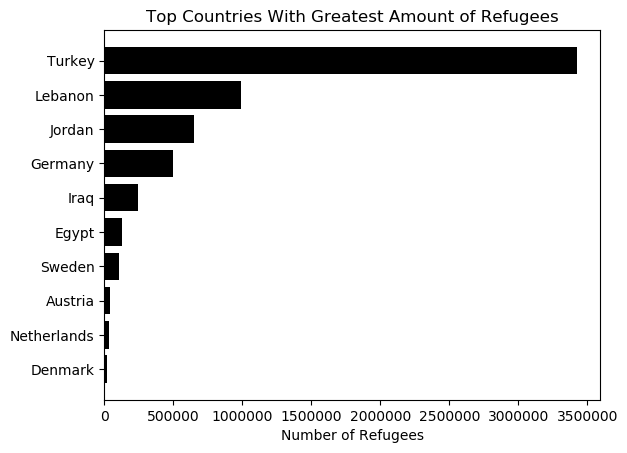

In [30]:
#https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barh.html
plt.rcdefaults()
fig, ax = plt.subplots()

# y_data will be the titles
y_data = []

max_countries = max_countries[:10]
x_data = max_countries['Refugees (incl. refugee-like situations)']
y_data = max_countries['Country']

# plot data
ax.barh(y_data, x_data, color='k', align='center')

# label data
ax.set_yticks(y_data)
ax.set_yticklabels(y_data)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Refugees')
ax.set_title('Top Countries With Greatest Amount of Refugees')

plt.show()

## Future Work

## Conclusion

## Appendix

## References